## Importing the Common Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from pprint import pprint
from sklearn.model_selection import train_test_split , cross_val_score , StratifiedKFold , RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,precision_score ,confusion_matrix, accuracy_score,f1_score , recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, make_scorer, mean_squared_error, r2_score

## Data Preproccessing

##### Connect to mongo database

In [2]:
client = MongoClient()
db=client.water_potability
potability = db.potability

##### Converting Data from CSV to Mongo DB Collection

In [3]:
# df = pd.read_csv('water_potability.csv')

# data = df.to_dict(orient="records")

# # Insert data into the MongoDB collection
# if data:  # Check if the list is not empty
#     potability.insert_many(data)
#     print(f"Inserted {len(data)} records into the '{potability}' collection.")
# else:
#     print("No data found in the CSV file to insert.")

##### Getting Data from mongo database

In [4]:
def mongo_to_df():

    try:
        df = pd.DataFrame(list(potability.find()))

        # Drop the '_id' column if you don't need it
        if '_id' in df.columns:
            df.drop(columns=['_id'], inplace=True)

        # Display the dataframe
        print("dataframe created successfully!")
        print(df.head())  # Display first 5 rows
        return df

    except Exception as e:
        print(f"An error occurred: {e}")

# Convert MongoDB collection to df
df = mongo_to_df()

dataframe created successfully!
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  


In [5]:
df

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225              NaN   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

In [6]:
print("All rows in the collection:")
for rows in potability.find():
 pprint(rows)

All rows in the collection:
{'Chloramines': 7.300211873184757,
 'Conductivity': 564.3086541722439,
 'Hardness': 204.8904554713363,
 'Organic_carbon': 10.3797830780847,
 'Potability': 0,
 'Solids': 20791.318980747023,
 'Sulfate': 368.51644134980336,
 'Trihalomethanes': 86.9909704615088,
 'Turbidity': 2.9631353806316407,
 '_id': ObjectId('676338c5e4e54195c92f640f'),
 'ph': nan}
{'Chloramines': 6.635245883862,
 'Conductivity': 592.8853591348523,
 'Hardness': 129.42292051494425,
 'Organic_carbon': 15.18001311635726,
 'Potability': 0,
 'Solids': 18630.057857970347,
 'Sulfate': nan,
 'Trihalomethanes': 56.32907628451764,
 'Turbidity': 4.500656274942408,
 '_id': ObjectId('676338c5e4e54195c92f6410'),
 'ph': 3.71608007538699}
{'Chloramines': 9.275883602694089,
 'Conductivity': 418.6062130644815,
 'Hardness': 224.23625939355776,
 'Organic_carbon': 16.868636929550973,
 'Potability': 0,
 'Solids': 19909.541732292397,
 'Sulfate': nan,
 'Trihalomethanes': 66.42009251176368,
 'Turbidity': 3.055933749

In [7]:
def search_ph():
    """
    Filters MongoDB documents in the 'ph' field based on user input (g for greater or l for lower)
    and prints the count of matching documents.
    """
    try:
        # Prompt user for threshold value and condition
        value = float(input("Enter the threshold value for 'ph': "))
        condition = input("Do you want values 'g' for greater or 'l' for lower than this? (Type 'g' or 'l'): ").strip().lower()
        
        # Define MongoDB query based on shorthand input
        if condition == "g":
            query = {"ph": {"$gt": value}}
            condition_text = "greater"
        elif condition == "l":
            query = {"ph": {"$lt": value}}
            condition_text = "lower"
        else:
            print("Invalid condition! Please type 'g' for greater or 'l' for lower.")
            return
            
        # Count documents that match the query
        count = potability.count_documents(query)
        
        # Fetch results
        results = potability.find(query)
        
        # Display count and matching documents
        print(f"\nNumber of documents where 'ph' is {condition_text} than {value}: {count}\n")
        if count > 0:
            print("Matching documents:\n")
            for doc in results:
                print(doc)
        else:
            print("No matching documents found.")
            
    except ValueError:
        print("Invalid input! Please enter a numeric value for the threshold.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the function
search_ph()



Number of documents where 'ph' is lower than 7.0: 1368

Matching documents:

{'_id': ObjectId('676338c5e4e54195c92f6410'), 'ph': 3.71608007538699, 'Hardness': 129.42292051494425, 'Solids': 18630.057857970347, 'Chloramines': 6.635245883862, 'Sulfate': nan, 'Conductivity': 592.8853591348523, 'Organic_carbon': 15.18001311635726, 'Trihalomethanes': 56.32907628451764, 'Turbidity': 4.500656274942408, 'Potability': 0}
{'_id': ObjectId('676338c5e4e54195c92f6414'), 'ph': 5.584086638456089, 'Hardness': 188.3133237696164, 'Solids': 28748.68773904612, 'Chloramines': 7.54486878877965, 'Sulfate': 326.6783629116736, 'Conductivity': 280.4679159334877, 'Organic_carbon': 8.399734640152758, 'Trihalomethanes': 54.91786184199447, 'Turbidity': 2.5597082275565217, 'Potability': 0}
{'_id': ObjectId('676338c5e4e54195c92f641e'), 'ph': 6.347271760539316, 'Hardness': 186.73288066057611, 'Solids': 41065.23476453935, 'Chloramines': 9.629596276480584, 'Sulfate': 364.4876872467604, 'Conductivity': 516.743281893657, 

#### Plot the distribution for each feature

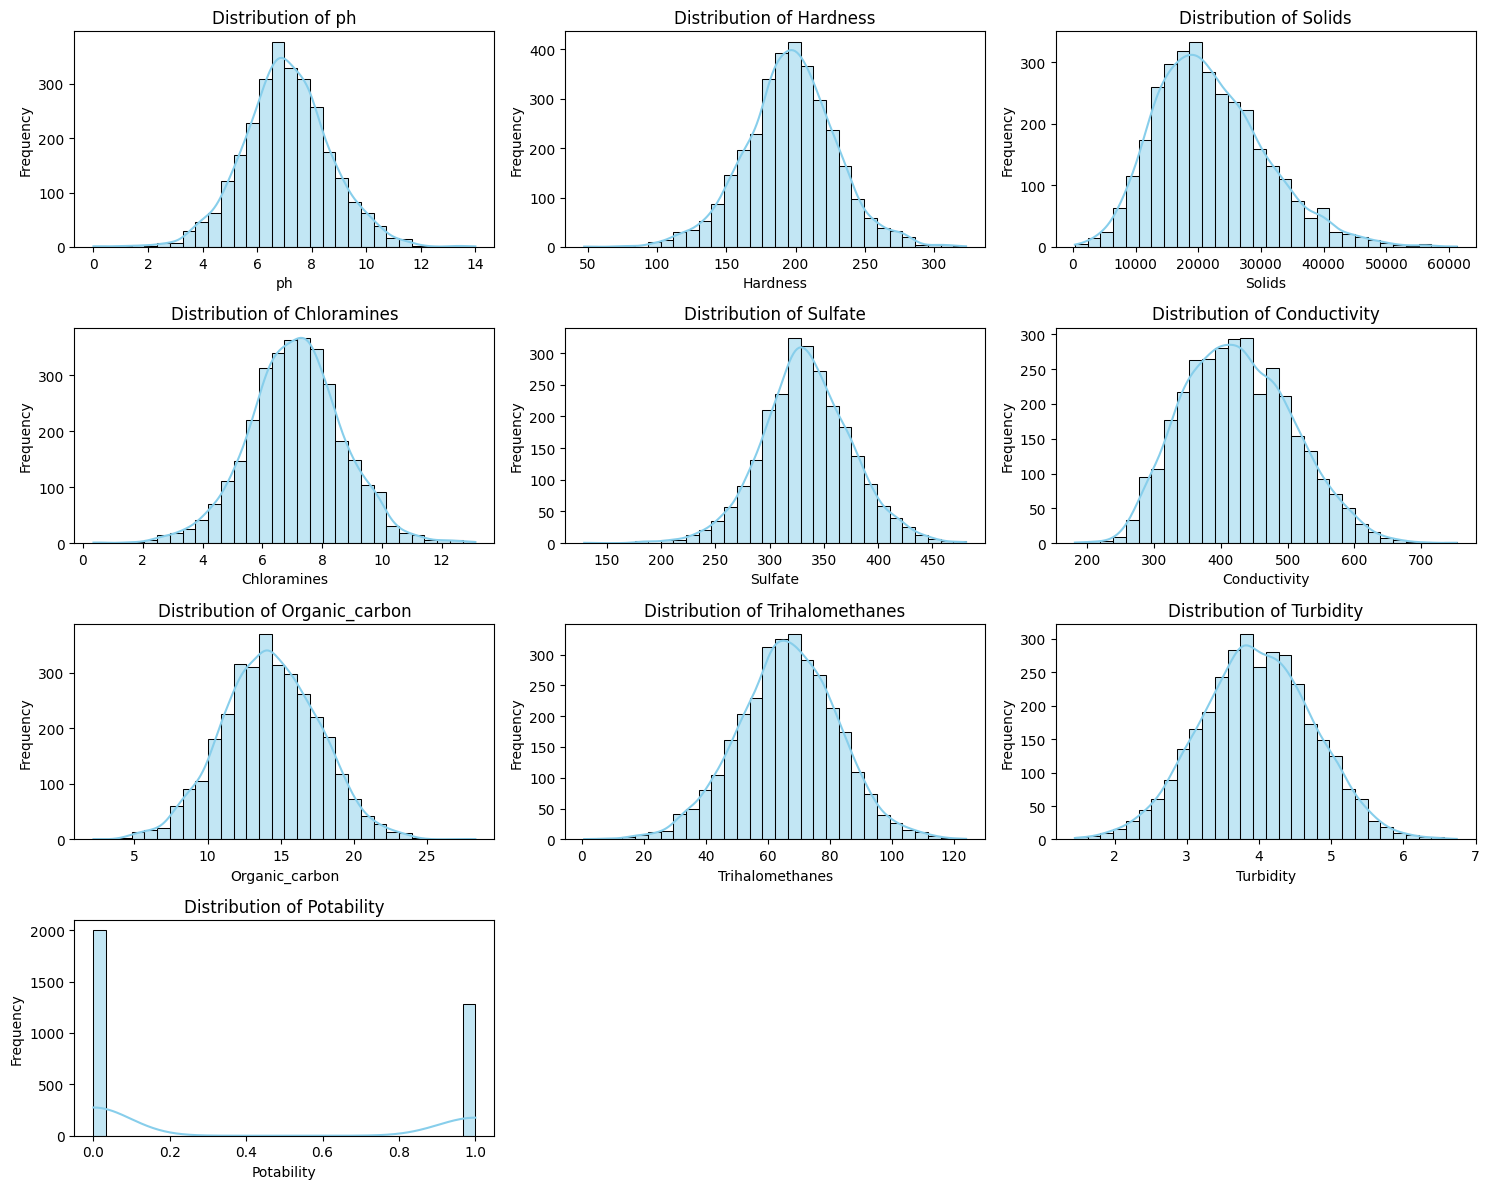

In [8]:
def plot_histograms():

        # List of numerical columns to plot
        columns = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", 
                   "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity", "Potability"]
        
        # Plot histograms for all columns
        plt.figure(figsize=(15, 12))  # Set the overall figure size
        for idx, col in enumerate(columns):
            plt.subplot(4, 3, idx + 1)  # Create subplots in a 4x3 grid
            sns.histplot(df[col], kde=True, color="skyblue", bins=30)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")

        plt.tight_layout()  # Adjust subplot spacing
        plt.show()  # Display all histograms


# Call the function
plot_histograms()

#### most of the feature are normally distributed

### Insights from the Visualizations
#### 1.pH Distribution

 The distribution of pH appears close to normal, peaking around 7 (neutral).

 There are a few extreme values on both the lower and higher ends.
#### 2. Hardness Distribution
Water hardness shows a normal distribution, with most samples clustering around 200 mg/L.

Values range from approximately 50 to 300 mg/L.
#### 3. Solids Distribution
Solids exhibit a right-skewed distribution, with a peak around 20,000–30,000 ppm.

Some extreme values exist on the higher end, indicating possible outliers.
#### 4. Chloramines Distribution
The chloramines distribution is relatively symmetric, peaking around 7 ppm.

Most values range between 2 and 12 ppm.
#### 5. Sulfate Distribution
The sulfate values follow a normal distribution, peaking between 300–350 mg/L.

Values span a range from 150 to 450 mg/L.
#### 6. Conductivity Distribution
The conductivity data is normally distributed, with a peak between 400–500 µS/cm.

Values range broadly between 200 and 700 µS/cm.
#### 7. Organic Carbon Distribution
Organic carbon distribution is normally distributed, peaking at around 14 ppm.

Most values fall between 5 and 20 ppm.
#### 8. Trihalomethanes Distribution
The trihalomethane values show a normal distribution, peaking around 50–60 μg/L.

The range extends up to 120 μg/L, with notable variation.

#### 9. Turbidity Distribution
Turbidity follows a symmetric distribution, peaking around 4 NTU.

Most values range between 2 and 6 NTU.

#### 10. Potability Distribution
Most samples are non-potable (0).

A smaller number of samples are potable (1), creating an imbalance in the dataset.

#### Exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [12]:
mean_=df.mean()
mean_

ph                     7.080795
Hardness             196.369496
Solids             22014.092526
Chloramines            7.122277
Sulfate              333.775777
Conductivity         426.205111
Organic_carbon        14.284970
Trihalomethanes       66.396293
Turbidity              3.966786
Potability             0.390110
dtype: float64

##### replacing the missing values with the mean

In [13]:
df.fillna(inplace=True,value=mean_)
df

ph    Hardness        Solids  Chloramines     Sulfate  \
0     7.080795  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246  333.775777   
2     8.099124  224.236259  19909.541732     9.275884  333.775777   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.775777   
3273  9.419510  175.762646  33155.578218     7.350233  333.775777   
3274  5.126763  230.603758  11983.869376     6.303357  333.775777   
3275  7.874671  195.102299  17404.177061     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225        66.396293   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

#### Statistical values about the dataset

In [14]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.469956    32.879761   8768.570828     1.583085    36.142612   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.277673   176.850538  15666.690297     6.127421   317.094638   
50%       7.080795   196.967627  20927.833607     7.130299   333.775777   
75%       7.870050   216.667456  27332.762127     8.114887   350.385756   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3276.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        15.769881     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        56.647656     3.439711     0.000000  
50%      421.884968       14.218338        66.396293     3.955028     0.000000  
75%      481.792304       16.557652        76.666609     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

#### Linear correlation between features

In [15]:
correlation=df.corr()
correlation

ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.075833 -0.081884    -0.031811  0.014403   
Hardness         0.075833  1.000000 -0.046899    -0.030054 -0.092766   
Solids          -0.081884 -0.046899  1.000000    -0.070148 -0.149840   
Chloramines     -0.031811 -0.030054 -0.070148     1.000000  0.023791   
Sulfate          0.014403 -0.092766 -0.149840     0.023791  1.000000   
Conductivity     0.017192 -0.023915  0.013831    -0.020486 -0.014059   
Organic_carbon   0.040061  0.003610  0.010242    -0.012653  0.026909   
Trihalomethanes  0.002994 -0.012690 -0.008875     0.016627 -0.025605   
Turbidity       -0.036222 -0.014449  0.019546     0.002363 -0.009790   
Potability      -0.003287 -0.013837  0.033743     0.023779 -0.020619   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
ph                   0.017192        0.040061         0.002994  -0.036222   
Hardness            -0.023915        0.003610        -0.012690  -0.014449   
Solids               0.013831        0.010242        -0.008875   0.019546   
Chloramines         -0.020486       -0.012653         0.016627   0.002363   
Sulfate             -0.014059        0.026909        -0.025605  -0.009790   
Conductivity         1.000000        0.020966         0.001255   0.005798   
Organic_carbon       0.020966        1.000000        -0.012976  -0.027308   
Trihalomethanes      0.001255       -0.012976         1.000000  -0.021502   
Turbidity            0.005798       -0.027308        -0.021502   1.000000   
Potability          -0.008128       -0.030001         0.006960   0.001581   

                 Potability  
ph                -0.003287  
Hardness          -0.013837  
Solids             0.033743  
Chloramines        0.023779  
Sulfate           -0.020619  
Conductivity      -0.008128  
Organic_carbon    -0.030001  
Trihalomethanes    0.006960  
Turbidity          0.001581  
Potability         1.000000

#### As we can see the correlation is very low between the features

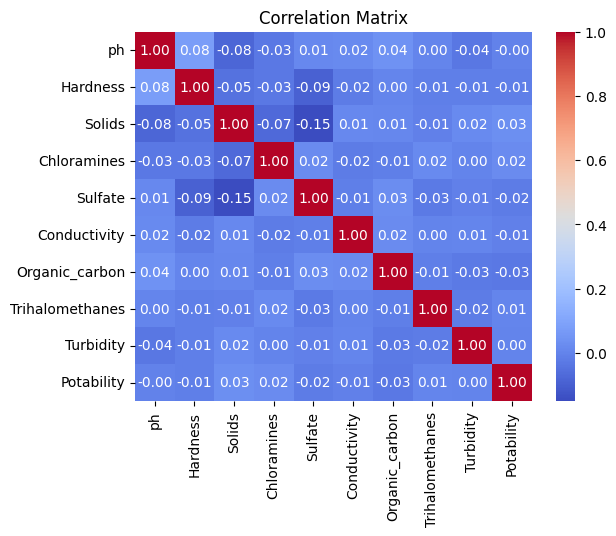

In [16]:
# Plotting the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### Use the boxplots to show the outliers in the columns

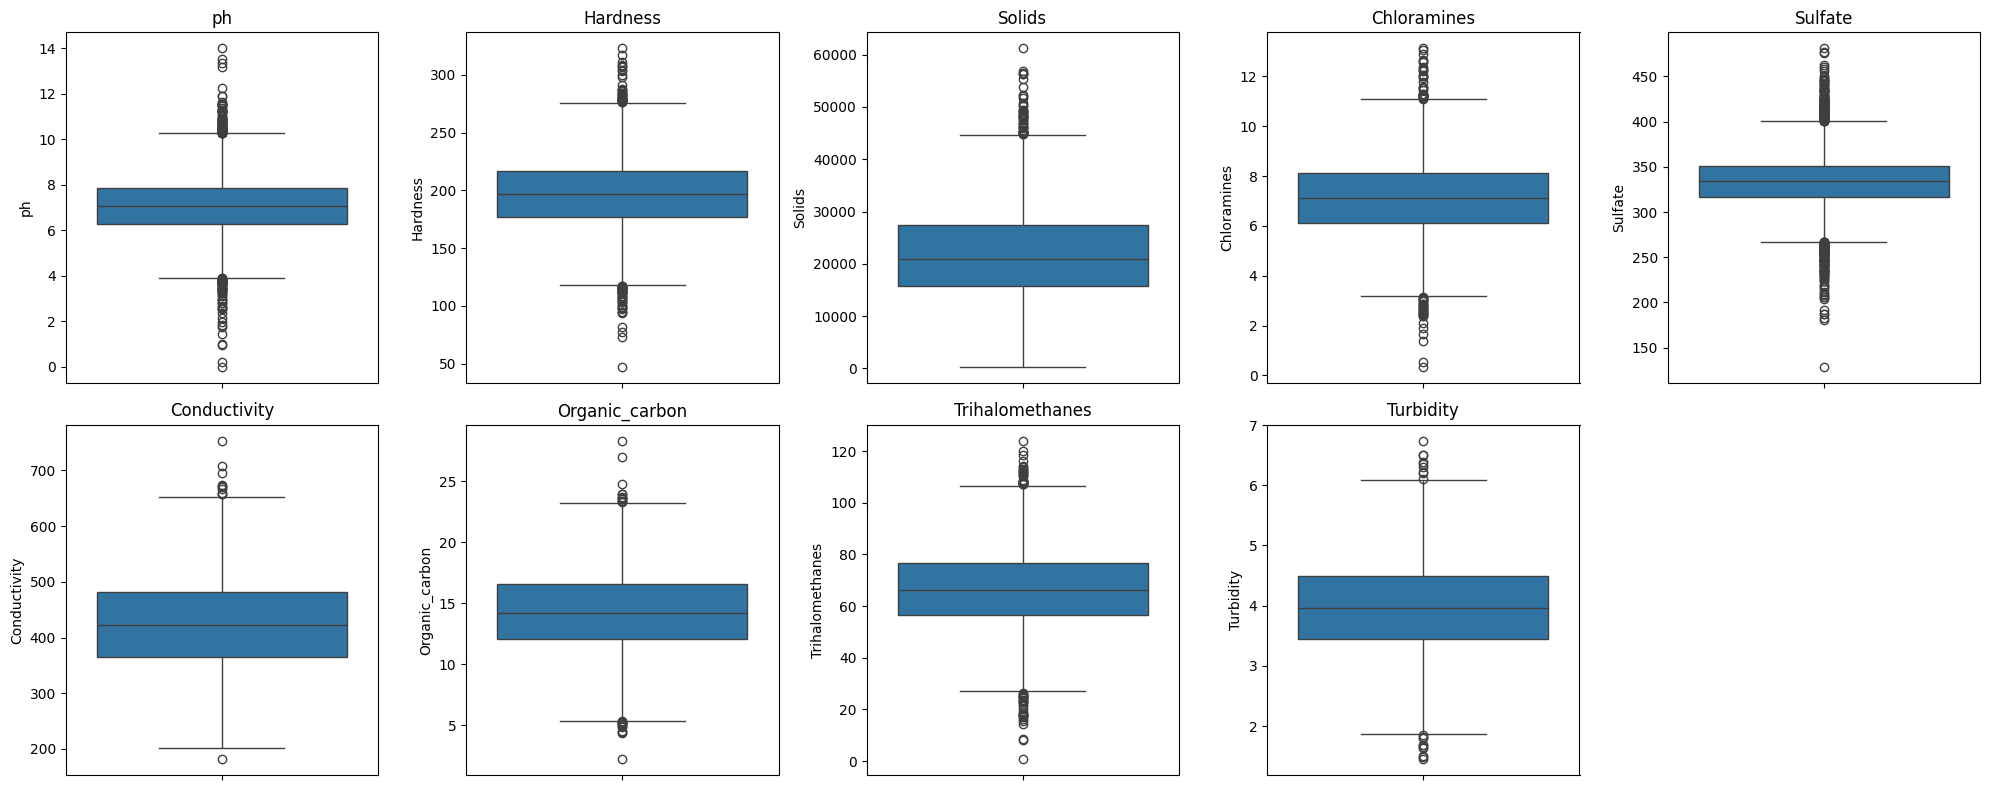

In [17]:
df_plotting=df.iloc[:,:-1]
plt.figure(figsize=(20, 8))

# Generate a boxplot for each column
for i, column in enumerate(df_plotting.columns, 1):
    plt.subplot(2, 5, i)  # 2 rows, 5 columns (adjust based on the number of parameters)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

#### Replace the outliers values with lovver and upper bound

In [18]:
def replace_outliers(df, columns):
    df = df.copy()

    # Filter numeric columns
    columns = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue  # Skip columns with no variation
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with boundary values using vectorized operations
        df[column] = np.where(df[column] < lower_bound, lower_bound,
                              np.where(df[column] > upper_bound, upper_bound, df[column]))
    
    return df

In [19]:
df=replace_outliers(df,df_plotting.columns)
df

ph    Hardness        Solids  Chloramines     Sulfate  \
0     7.080795  204.890455  20791.318981     7.300212  368.516441   
1     3.889107  129.422921  18630.057858     6.635246  333.775777   
2     8.099124  224.236259  19909.541732     9.275884  333.775777   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  44831.869873     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.775777   
3273  9.419510  175.762646  33155.578218     7.350233  333.775777   
3274  5.126763  230.603758  11983.869376     6.303357  333.775777   
3275  7.874671  195.102299  17404.177061     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225        66.396293   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

#### Dispaly the boxplot after replacing and we can see that the outliers have gone

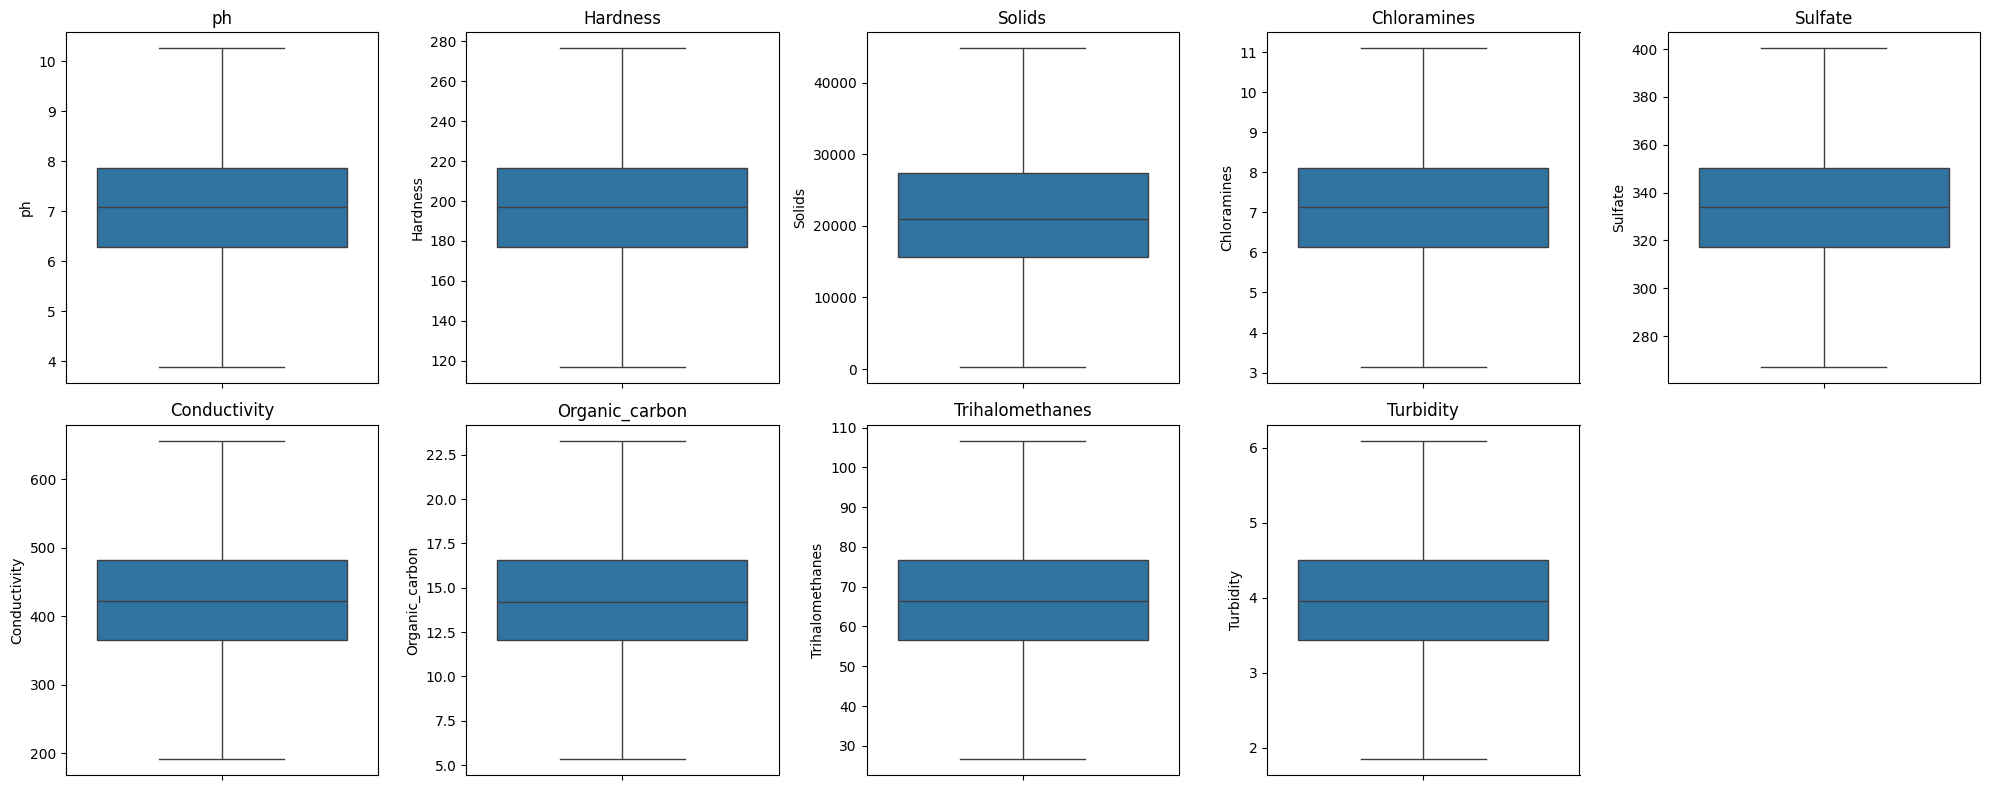

In [20]:
df_plotting=df.iloc[:,:-1]
plt.figure(figsize=(20, 8))

# Generate a boxplot for each column
for i, column in enumerate(df_plotting.columns, 1):
    plt.subplot(2, 5, i)  # 2 rows, 5 columns (adjust based on the number of parameters)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [21]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean      7.079949   196.392423  21957.112200     7.121794   333.788678   
std       1.381951    32.017189   8592.820397     1.544126    31.768004   
min       3.889107   117.125160    320.942611     3.146221   267.157960   
25%       6.277673   176.850538  15666.690297     6.127421   317.094638   
50%       7.080795   196.967627  20927.833607     7.130299   333.775777   
75%       7.870050   216.667456  27332.762127     8.114887   350.385756   
max      10.258615   276.392834  44831.869873    11.096086   400.322434   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3276.000000  3276.000000  3276.000000  
mean     426.129974       14.283462        66.420427     3.966612     0.390110  
std       80.564144        3.288367        15.487146     0.776409     0.487849  
min      191.647579        5.328026        26.619225     1.848797     0.000000  
25%      365.734414       12.065801        56.647656     3.439711     0.000000  
50%      421.884968       14.218338        66.396293     3.955028     0.000000  
75%      481.792304       16.557652        76.666609     4.500320     1.000000  
max      655.879140       23.295427       106.695040     6.091233     1.000000

In [22]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

#### Standardize the values to make the algorithms faster and avoid baisness towords the large values features

In [23]:
scaler=StandardScaler()

x=scaler.fit_transform(x)
x

array([[ 6.12122530e-04,  2.65461463e-01, -1.35691325e-01, ...,
        -1.18729897e+00,  1.32843613e+00, -1.29265686e+00],
       [-2.30929249e+00, -2.09199269e+00, -3.87249133e-01, ...,
         2.72685046e-01, -6.51694738e-01,  6.87944100e-01],
       [ 7.37602948e-01,  8.69785504e-01, -2.38324899e-01, ...,
         7.86277885e-01, -2.16021711e-05, -1.17311602e+00],
       ...,
       [ 1.69319962e+00, -6.44432768e-01,  1.30343415e+00, ...,
        -9.86777764e-01,  2.21183182e-01, -8.60163745e-01],
       [-1.41356972e+00,  1.06869335e+00, -1.16082554e+00, ...,
        -9.47275978e-01,  7.14752479e-01,  9.55887998e-01],
       [ 5.75160784e-01, -4.03008905e-02, -5.29934292e-01, ...,
         5.64775679e-01,  7.92908778e-01, -2.13510781e+00]],
      shape=(3276, 9))

#### sakora describe for the data

In [24]:
f=pd.DataFrame(x)
f.describe()

0             1             2             3             4  \
count  3.276000e+03  3.276000e+03  3.276000e+03  3.276000e+03  3.276000e+03   
mean  -5.612116e-16 -1.507409e-16 -2.271958e-16 -2.776235e-16 -2.056149e-15   
std    1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00   
min   -2.309292e+00 -2.476150e+00 -2.518320e+00 -2.575035e+00 -2.097736e+00   
25%   -5.806274e-01 -6.104492e-01 -7.321673e-01 -6.440698e-01 -5.255788e-01   
50%    6.121225e-04  1.796822e-02 -1.198018e-01  5.508795e-03 -4.061619e-04   
75%    5.718160e-01  6.333513e-01  6.256933e-01  6.432406e-01  5.225261e-01   
max    2.300481e+00  2.499052e+00  2.662484e+00  2.574206e+00  2.094683e+00   

                  5             6             7             8  
count  3.276000e+03  3.276000e+03  3.276000e+03  3.276000e+03  
mean  -9.353527e-16  1.735147e-17 -1.301360e-16 -7.157482e-17  
std    1.000153e+00  1.000153e+00  1.000153e+00  1.000153e+00  
min   -2.910950e+00 -2.723785e+00 -2.570343e+00 -2.728123e+00  
25%   -7.497725e-01 -6.744986e-01 -6.311210e-01 -6.787427e-01  
50%   -5.269904e-02 -1.980727e-02 -1.558567e-03 -1.492293e-02  
75%    6.910125e-01  6.916921e-01  6.616937e-01  6.875106e-01  
max    2.852190e+00  2.740978e+00  2.600916e+00  2.736891e+00

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

In [26]:
x_train.shape , x_test.shape

((2293, 9), (983, 9))

In [27]:
y_train

2985    0
1073    1
3140    1
2643    0
2174    0
       ..
1095    1
1130    1
1294    0
860     0
3174    1
Name: Potability, Length: 2293, dtype: int64

## Logistic Regression Model:

In [28]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l1',solver='liblinear')

In [29]:
model_lr.fit(x_train,y_train)
y_pred_lr=model_lr.predict(x_test)
y_learning_lr=model_lr.predict(x_train)
y_pred_lr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
accuracy_score_lr=accuracy_score(y_test,y_pred_lr)
f1_score_lr=f1_score(y_test,y_pred_lr)
recall_score_lr=recall_score(y_test,y_pred_lr)
precision_score_lr=precision_score(y_test,y_pred_lr)
L_accuracy_score_lr=accuracy_score(y_train,y_learning_lr)
print(f"Testing Accuracy Score: {accuracy_score_lr*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_lr*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_lr*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_lr*100:0.3f}%")
print(f"Testing precision Score: {precision_score_lr*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Testing Accuracy Score: 62.767%
Learning Accuracy Score: 60.227%
Testing F1-Score: 0.000%
Testing Recall Score: 0.000%
Testing precision Score: 0.000%
Classification Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77       617
           1       0.00      0.00      0.00       366

    accuracy                           0.63       983
   macro avg       0.31      0.50      0.39       983
weighted avg       0.39      0.63      0.48       983



/home/muhammed_mahmoud/python_projects/python_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/muhammed_mahmoud/python_projects/python_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/muhammed_mahmoud/python_projects/python_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

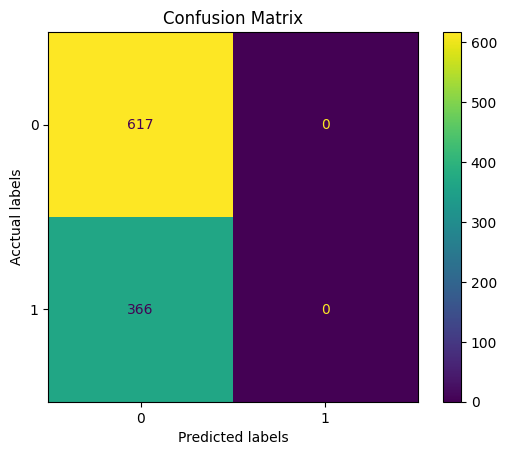

In [31]:
confusion_m=confusion_matrix(y_test,y_pred_lr)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

#### As we can see the logistic regression does not fit the data well

### Grid Search for the Logistic Regression Model Best Parameters:

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)


{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


## K-Nearest Neighbor Model:

In [33]:
from sklearn.neighbors import KNeighborsClassifier
k = 11
model_knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')

In [34]:
# Predictions on training and testing data
model_knn.fit(x_train,y_train)
y_pred_knn = model_knn.predict(x_test)
y_learning_knn = model_knn.predict(x_train)

In [35]:
accuracy_score_knn=accuracy_score(y_test,y_pred_knn)
f1_score_knn=f1_score(y_test,y_pred_knn)
recall_score_knn=recall_score(y_test,y_pred_knn)
precision_score_knn=precision_score(y_test,y_pred_knn)
L_accuracy_score_knn=accuracy_score(y_train,y_learning_knn)
print(f"Testing Accuracy Score: {accuracy_score_knn*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_knn*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_knn*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_knn*100:0.3f}%")
print(f"Testing precision Score: {precision_score_knn*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Testing Accuracy Score: 65.717%
Learning Accuracy Score: 71.086%
Testing F1-Score: 42.978%
Testing Recall Score: 34.699%
Testing precision Score: 56.444%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75       617
           1       0.56      0.35      0.43       366

    accuracy                           0.66       983
   macro avg       0.62      0.59      0.59       983
weighted avg       0.64      0.66      0.63       983



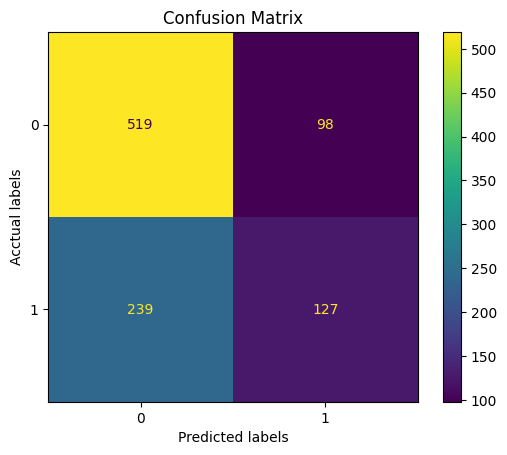

In [36]:
confusion_m=confusion_matrix(y_test,y_pred_knn)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

#### The KNN perform better but due to the imbalance in the data the accuracy for the 1 class is not satisfaied

##### Search for the best Parameters for the KNN Model

In [37]:
# Define a range for k values
k_values = range(1, 60, 2)  # Odd values to avoid ties
best_k = 0
best_f1 = 0
performance_metrics = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    
    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store performance metrics
    performance_metrics.append((k, acc, precision, recall, f1))
    
    # Update the best k based on F1-score
    if f1 > best_f1:
        best_k = k
        best_f1 = f1

# Output the best k
print(f"Best k value: {best_k} with F1-score: {recall:.4f}")

Best k value: 11 with F1-score: 0.6592


#### Minkowski and Eculidean are equal and manhatten decreases the accuracy

In [38]:
distance_metrics = ['euclidean', 'manhattan', 'minkowski']
for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    
    # Evaluate performance
    print(f"\nMetric: {metric}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))


Metric: euclidean
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75       617
           1       0.56      0.35      0.43       366

    accuracy                           0.66       983
   macro avg       0.62      0.59      0.59       983
weighted avg       0.64      0.66      0.63       983

Accuracy: 0.6571719226856562

Metric: manhattan
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.74       617
           1       0.54      0.35      0.42       366

    accuracy                           0.64       983
   macro avg       0.61      0.58      0.58       983
weighted avg       0.63      0.64      0.62       983

Accuracy: 0.6449643947100712

Metric: minkowski
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75       617
           1       0.56      0.35      0.43       

## Naive Bayes Model:

#### We choosed the GaussianNB (Normal naive bayes) as our data is normaly distributed

In [39]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
#model_nb.score

In [40]:
model_nb.fit(x_train, y_train)
y_pred_nb = model_nb.predict(x_test)
y_learning_nb = model_nb.predict(x_train)

In [41]:
accuracy_score_nb=accuracy_score(y_test,y_pred_nb)
f1_score_nb=f1_score(y_test,y_pred_nb)
recall_score_nb=recall_score(y_test,y_pred_nb)
precision_score_nb=precision_score(y_test,y_pred_nb)
L_accuracy_score_nb=accuracy_score(y_train,y_learning_nb)
print(f"Testing Accuracy Score: {accuracy_score_nb*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_nb*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_nb*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_nb*100:0.3f}%")
print(f"Testing precision Score: {precision_score_nb*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Testing Accuracy Score: 63.276%
Learning Accuracy Score: 62.189%
Testing F1-Score: 27.071%
Testing Recall Score: 18.306%
Testing precision Score: 51.938%
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.90      0.75       617
           1       0.52      0.18      0.27       366

    accuracy                           0.63       983
   macro avg       0.58      0.54      0.51       983
weighted avg       0.60      0.63      0.57       983



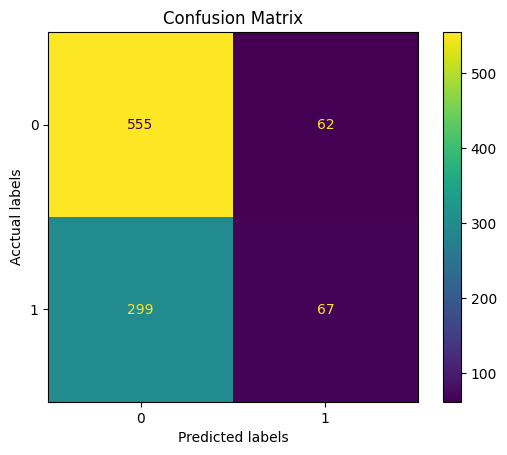

In [42]:
confusion_m=confusion_matrix(y_test,y_pred_nb)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

## Support Vector Machine Model (SVM):

In [43]:
from sklearn import svm
#model_svm = svm.SVC(kernel= 'rbf', degree= 3, random_state= 42, C= 1, class_weight={0: 1, 1: 1.5}, probability= True, gamma= 'auto')
model_svm = svm.SVC(kernel= 'rbf')

In [44]:
model_svm.fit(x_train,y_train)
y_pred_svm = model_svm.predict(x_test)
y_learning_svm = model_svm.predict(x_train)

In [45]:
accuracy_score_svm=accuracy_score(y_test,y_pred_svm)
f1_score_svm=f1_score(y_test,y_pred_svm)
recall_score_svm=recall_score(y_test,y_pred_svm)
precision_score_svm=precision_score(y_test,y_pred_svm)
L_accuracy_score_svm=accuracy_score(y_train,y_learning_svm)
print(f"Testing Accuracy Score: {accuracy_score_svm*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_svm*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_svm*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_svm*100:0.3f}%")
print(f"Testing precision Score: {precision_score_svm*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Testing Accuracy Score: 68.667%
Learning Accuracy Score: 72.656%
Testing F1-Score: 41.667%
Testing Recall Score: 30.055%
Testing precision Score: 67.901%
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.92      0.79       617
           1       0.68      0.30      0.42       366

    accuracy                           0.69       983
   macro avg       0.68      0.61      0.60       983
weighted avg       0.68      0.69      0.65       983



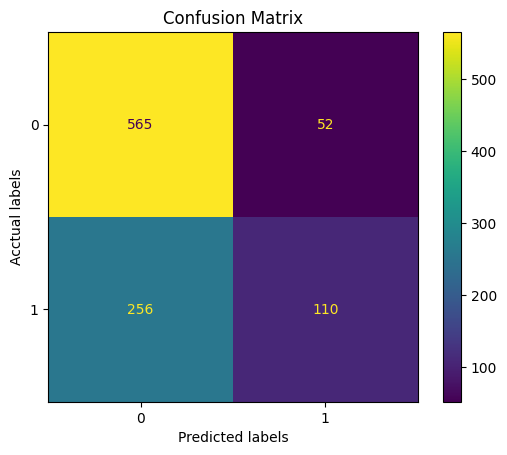

In [46]:
confusion_m=confusion_matrix(y_test,y_pred_svm)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

## Grid search on svm

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
param_grid = {
    'C': [0.1, 1, 10],              # Test different values for C regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid',],    # Test both linear and RBF kernels
    'gamma': ['scale', 'auto'],     # Options for gamma in RBF kernel
    'class_weight': [None, {0: 1, 1: 1.5}],  # Test different class weights
}

In [49]:
svc = svm.SVC(random_state=42, probability=True)

In [50]:
grid_search = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    scoring='f1',  # Metric for evaluation (use others if needed)
    cv=5,                # 5-fold cross-validation
    verbose=2,           # For detailed output
    n_jobs=-1            # Use all processors
)

In [51]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END C=0.1, class_weight=None, gamma=scale, kernel=linear; total time=   1.0s
[CV] END C=0.1, class_weight=None, gamma=scale, kernel=linear; total time=   1.1s
[CV] END C=0.1, class_weight=None, gamma=scale, kernel=linear; total time=   1.6s
[CV] END C=0.1, class_weight=None, gamma=scale, kernel=linear; total time=   1.6s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=   3.6s
[CV] END C=0.1, class_weight=None, gamma=scale, kernel=linear; total time=   2.9s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=   3.5s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=   3.3s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=   3.2s
[CV] END .C=0.1, class_weight=None, gamma=scale, kernel=poly; total time=   2.9s
[CV] END .C=0.1, class_weight=None, gamma=

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'class_weight': [None, {0: 1, 1: 1.5}],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='f1', verbose=2)

In [52]:
grid_search.best_estimator_

SVC(C=1, class_weight={0: 1, 1: 1.5}, probability=True, random_state=42)

In [53]:
y_pred_svmgds = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred_svmgds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       617
           1       0.55      0.55      0.55       366

    accuracy                           0.66       983
   macro avg       0.64      0.64      0.64       983
weighted avg       0.66      0.66      0.66       983



In [54]:
accuracy_score_svmgds=accuracy_score(y_test,y_pred_svmgds)
f1_score_svmgds=f1_score(y_test,y_pred_svmgds)
recall_score_svmgds=recall_score(y_test,y_pred_svmgds)
precision_score_svmgds=precision_score(y_test,y_pred_svmgds)
L_accuracy_score_svmgds=accuracy_score(y_train,y_learning_svm)
print(f"Testing Accuracy Score: {accuracy_score_svmgds*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_svmgds*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_svmgds*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_svmgds*100:0.3f}%")
print(f"Testing precision Score: {precision_score_svmgds*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_svmgds))

Testing Accuracy Score: 66.328%
Learning Accuracy Score: 72.656%
Testing F1-Score: 54.843%
Testing Recall Score: 54.918%
Testing precision Score: 54.768%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       617
           1       0.55      0.55      0.55       366

    accuracy                           0.66       983
   macro avg       0.64      0.64      0.64       983
weighted avg       0.66      0.66      0.66       983



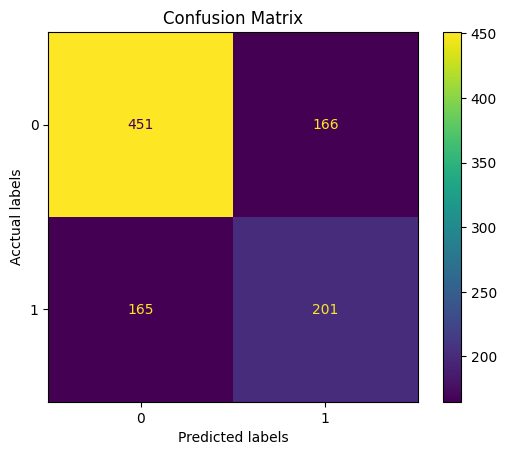

In [55]:
confusion_m=confusion_matrix(y_test,y_pred_svmgds)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree Model:

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model_dt = DecisionTreeClassifier(max_depth=10, criterion= "entropy", min_samples_leaf = 2, min_samples_split = 18)

In [57]:
model_dt.fit(x_train,y_train)
y_pred_dt = model_dt.predict(x_test)
y_learning_dt = model_dt.predict(x_train)

In [58]:
accuracy_score_dt=accuracy_score(y_test,y_pred_dt)
f1_score_dt=f1_score(y_test,y_pred_dt)
recall_score_dt=recall_score(y_test,y_pred_dt)
precision_score_dt=precision_score(y_test,y_pred_dt)
L_accuracy_score_dt=accuracy_score(y_train,y_learning_dt)
print(f"Testing Accuracy Score: {accuracy_score_dt*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_dt*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_dt*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_dt*100:0.3f}%")
print(f"Testing precision Score: {precision_score_dt*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Testing Accuracy Score: 63.683%
Learning Accuracy Score: 71.696%
Testing F1-Score: 34.254%
Testing Recall Score: 25.410%
Testing precision Score: 52.542%
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.86      0.75       617
           1       0.53      0.25      0.34       366

    accuracy                           0.64       983
   macro avg       0.59      0.56      0.55       983
weighted avg       0.61      0.64      0.60       983



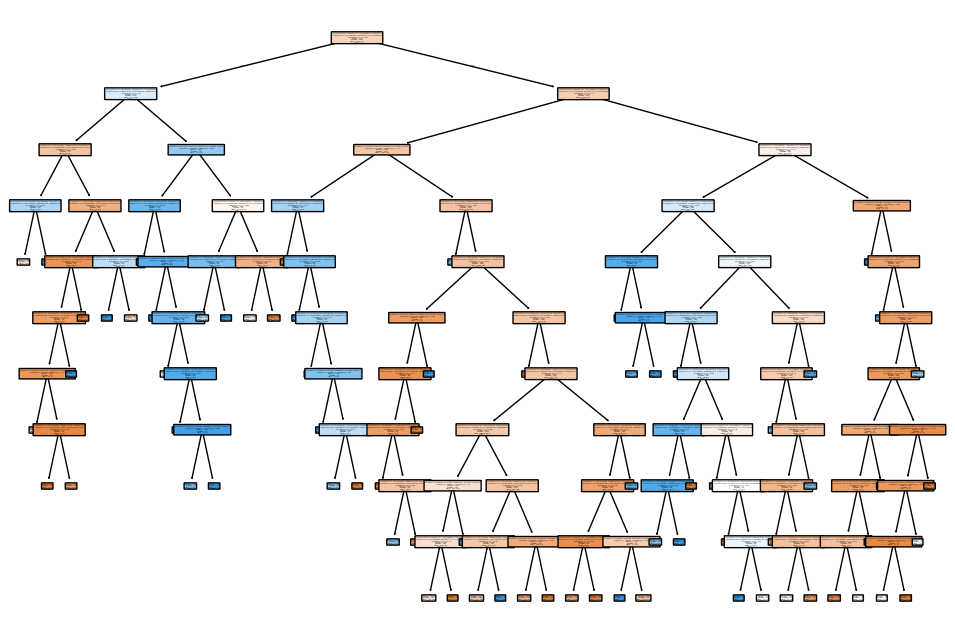

In [59]:
feature_names = [value for value in x_train]
class_names = [str(name) for name in model_dt.classes_]  # Ensure class names are strings

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(
    model_dt, 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True
)
plt.show()

In [60]:
tree = model_dt.tree_

In [61]:
df.iloc[:, :-1].columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

In [62]:
from sklearn.tree import export_text

tree_text = export_text(model_dt, feature_names= df.iloc[:, :-1].columns)
print(tree_text)

|--- Sulfate <= -1.22
|   |--- ph <= -0.12
|   |   |--- Chloramines <= -0.90
|   |   |   |--- Solids <= 0.57
|   |   |   |   |--- class: 0
|   |   |   |--- Solids >  0.57
|   |   |   |   |--- class: 1
|   |   |--- Chloramines >  -0.90
|   |   |   |--- Chloramines <= 0.93
|   |   |   |   |--- Conductivity <= 0.69
|   |   |   |   |   |--- Conductivity <= 0.54
|   |   |   |   |   |   |--- Hardness <= -0.51
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Hardness >  -0.51
|   |   |   |   |   |   |   |--- Chloramines <= 0.34
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Chloramines >  0.34
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Conductivity >  0.54
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Conductivity >  0.69
|   |   |   |   |   |--- class: 0
|   |   |   |--- Chloramines >  0.93
|   |   |   |   |--- Organic_carbon <= -0.84
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Organic_c

## Insights
#### The sulfate feature is the most important feature it has the lowest entropy and the highest information gain
#### Then the PH

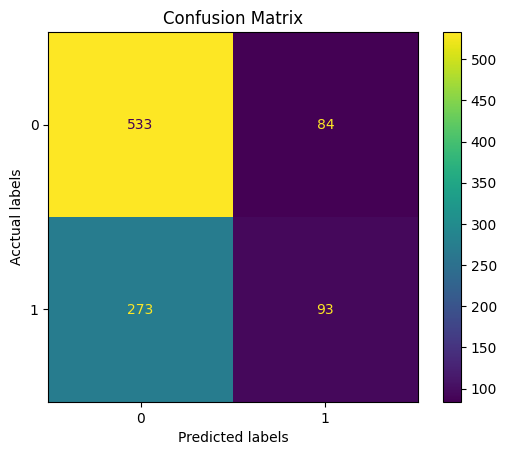

In [63]:
confusion_m=confusion_matrix(y_test,y_pred_dt)
display=ConfusionMatrixDisplay(confusion_matrix=confusion_m)
display.plot()
plt.xlabel('Predicted labels')
plt.ylabel('Acctual labels')
plt.title('Confusion Matrix')
plt.show()

##### Experiment with Different Hyperparameters:

In [64]:
# Experiment with Gini
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf = 10, random_state=42)
clf_gini.fit(x_train, y_train)
y_pred_gini = clf_gini.predict(x_test)
f1_gini = f1_score(y_test, y_pred_gini, average='weighted')

print(f"F1 Score with Gini: {f1_gini}")

# Experiment with Entropy
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=2, min_samples_leaf = 10, random_state=42)
clf_entropy.fit(x_train, y_train)
y_pred_entropy = clf_entropy.predict(x_test)
f1_entropy = f1_score(y_test, y_pred_entropy, average='weighted')

print(f"F1 Score with Entropy: {f1_entropy}")

F1 Score with Gini: 0.5900717239134561
F1 Score with Entropy: 0.5958017332667914


##### Grid Search For The Desicion Model Tree Best Parameters:

In [65]:
# Define parameter grid for Grid Search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}
# Define scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Initialize Decision Tree Classifier
base_model = DecisionTreeClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1
)

# Fit Grid Search
grid_search.fit(x_train, y_train)

# Get the best parameters and F1 score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best F1 Score from Grid Search:", grid_search.best_score_)

# Evaluate on test data using the best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("F1 Score on Test Data with Best Model:", f1_test)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Parameters from Grid Search: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best F1 Score from Grid Search: 0.5932470753288656
F1 Score on Test Data with Best Model: 0.6115060267455965


##### Randomized Search For The Desicion Model Tree Best Parameters:

In [66]:
# Define parameter distribution for Randomized Search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 11)
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=50,
    cv=5,
    random_state=42,
    verbose=1
)

# Fit Randomized Search
random_search.fit(x_train, y_train)

# Get the best parameters and F1 score from Randomized Search
print("Best Parameters from Randomized Search:", random_search.best_params_)
print("Best F1 Score from Randomized Search:", random_search.best_score_)

# Evaluate on test data using the best model from Randomized Search
best_random_model = random_search.best_estimator_
y_test_pred_random = best_random_model.predict(x_test)
f1_test_random = f1_score(y_test, y_test_pred_random, average='weighted')
print("F1 Score on Test Data with Randomized Search Best Model:", f1_test_random)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from Randomized Search: {'min_samples_split': 11, 'min_samples_leaf': 3, 'max_depth': 10, 'criterion': 'gini'}
Best F1 Score from Randomized Search: 0.5886285205672661
F1 Score on Test Data with Randomized Search Best Model: 0.611566274455936


## Random Forest Model:

In [67]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,      
    min_samples_split=10,  
    min_samples_leaf=5,    
    max_features='sqrt',  
    bootstrap=True,        
    oob_score=True, class_weight='balanced',  
    random_state=42, ccp_alpha=0.001, criterion='gini')

In [68]:
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
y_learning_rf = model_rf.predict(x_train)
y_prob_rf = model_rf.predict_proba(x_test)[:, 1]

In [69]:
accuracy_score_rf=accuracy_score(y_test,y_pred_rf)
f1_score_rf=f1_score(y_test,y_pred_rf)
recall_score_rf=recall_score(y_test,y_pred_rf)
precision_score_rf=precision_score(y_test,y_pred_rf)
L_accuracy_score_rf=accuracy_score(y_train,y_learning_rf)
cv_scores = cross_val_score(model_rf, x, y, cv=5, scoring='accuracy')
roc_auc = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC Score:", roc_auc)
print("Cross-Validation Accuracy:", np.mean(cv_scores)*100,"%")
print(f"Testing Accuracy Score: {accuracy_score_rf*100:0.3f}%")
print(f"Learning Accuracy Score: {L_accuracy_score_rf*100:0.3f}%")
print(f"Testing F1-Score: {f1_score_rf*100:0.3f}%")
print(f"Testing Recall Score: {recall_score_rf*100:0.3f}%")
print(f"Testing precision Score: {precision_score_rf*100:0.3f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


ROC-AUC Score: 0.7005296206746907
Cross-Validation Accuracy: 60.5319772854217 %
Testing Accuracy Score: 67.752%
Learning Accuracy Score: 87.963%
Testing F1-Score: 52.331%
Testing Recall Score: 47.541%
Testing precision Score: 58.194%
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.80      0.76       617
           1       0.58      0.48      0.52       366

    accuracy                           0.68       983
   macro avg       0.65      0.64      0.64       983
weighted avg       0.67      0.68      0.67       983



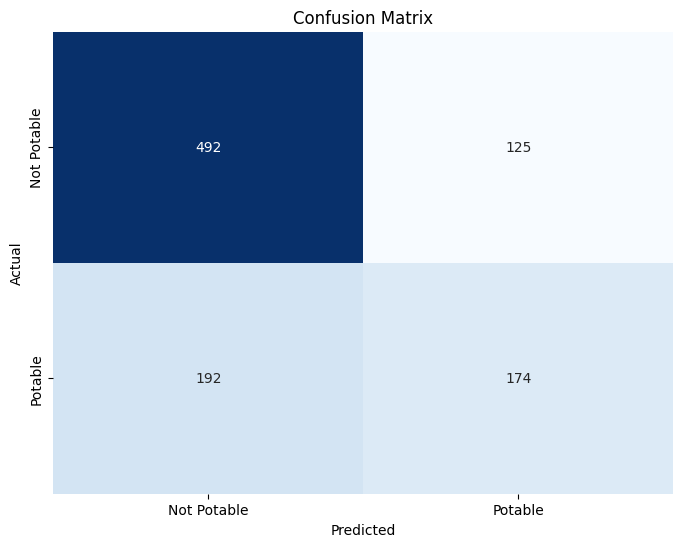

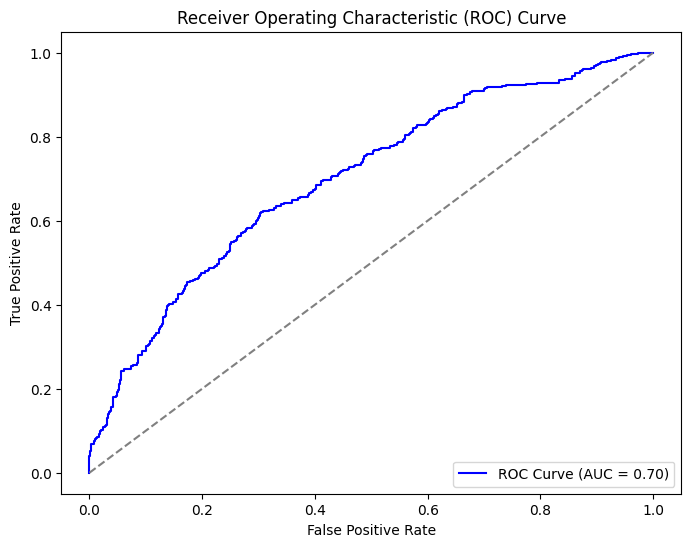

In [70]:
confusion_m=confusion_matrix(y_test,y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_m, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### The more curveture in the ROC curve the more accurate the model 

## Visualization

#### We made a dataframe for the results form the models

In [71]:
measurements = pd.DataFrame({
'models': ['logistic_regression', 'knn', 'naive_bayes', 'svm', 'decision_tree', 'random_forest'],
'accuracy_score': [accuracy_score_lr,
                   accuracy_score_knn,
                   accuracy_score_nb,
                   accuracy_score_svm,
                   accuracy_score_dt,
                   accuracy_score_rf],
    'f1_score': [f1_score_lr,
                   f1_score_knn,
                   f1_score_nb,
                   f1_score_svm,
                   f1_score_dt,
                   f1_score_rf],

    'precision': [precision_score_lr,
                   precision_score_knn,
                   precision_score_nb,
                   precision_score_svm,
                   precision_score_dt,
                   precision_score_rf],
    'recall': [recall_score_lr,
                   recall_score_knn,
                   recall_score_nb,
                   recall_score_svm,
                   recall_score_dt,
                   recall_score_rf],
})

In [72]:
measurements

models  accuracy_score  f1_score  precision    recall
0  logistic_regression        0.627670  0.000000   0.000000  0.000000
1                  knn        0.657172  0.429780   0.564444  0.346995
2          naive_bayes        0.632757  0.270707   0.519380  0.183060
3                  svm        0.686673  0.416667   0.679012  0.300546
4        decision_tree        0.636826  0.342541   0.525424  0.254098
5        random_forest        0.677518  0.523308   0.581940  0.475410

#### Plotting the accuracy score for each model

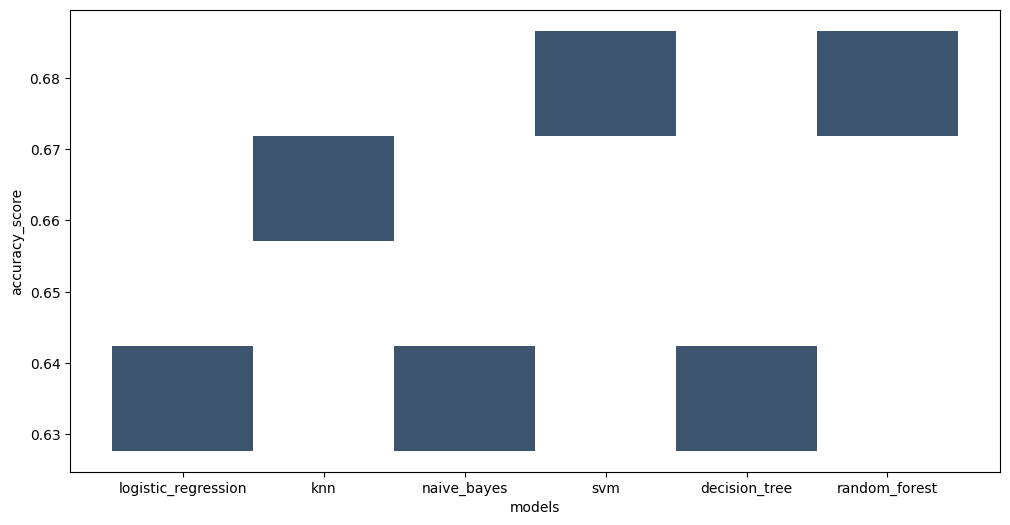

In [73]:
plt.figure(figsize=(12, 6)) 
sns.histplot(x= measurements['models'], y= measurements['accuracy_score'])
plt.show()

#### SVM and the Random forest is the best in accuracy
#### Logistic, Naive bayes, Decision tree is the worst algorithms

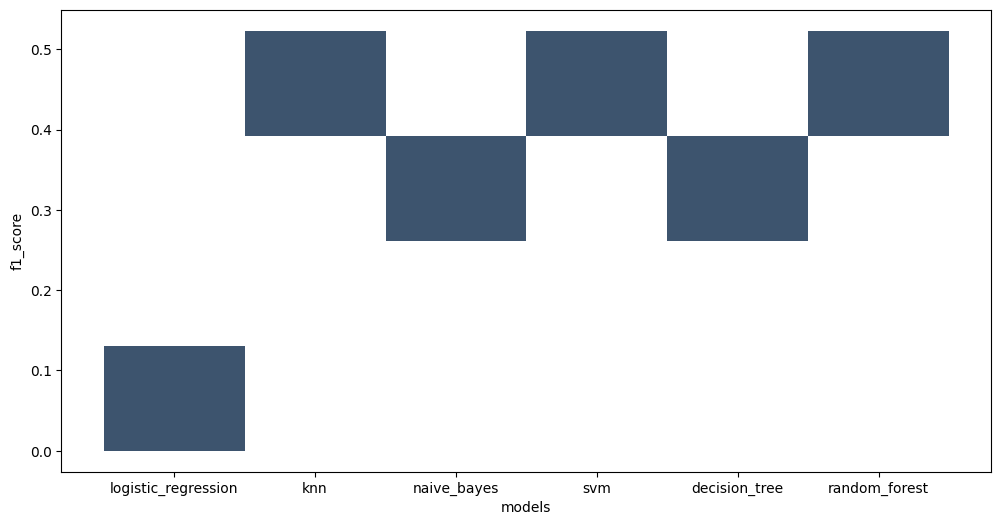

In [74]:
plt.figure(figsize=(12, 6)) 
sns.histplot(x= measurements['models'], y= measurements['f1_score'])
plt.show()

#### For the F1 score most of the alogorithms are kinda equal and do not exceed 0.6

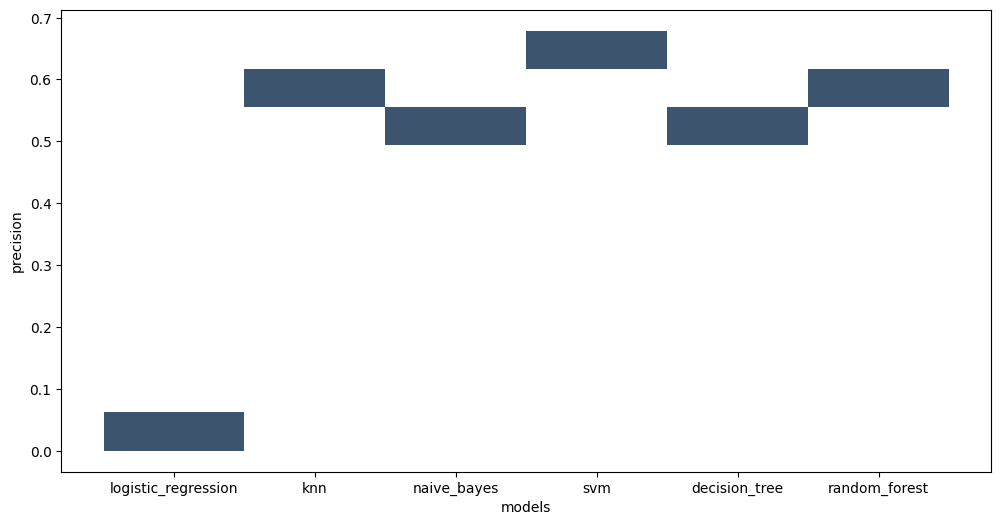

In [75]:
plt.figure(figsize=(12, 6)) 
sns.histplot(x= measurements['models'], y= measurements['precision'])
plt.show()

#### For percision the SVM is the best
#### and the logistic remain in 0 
#### Other algorithms are slightly lower then the SVM

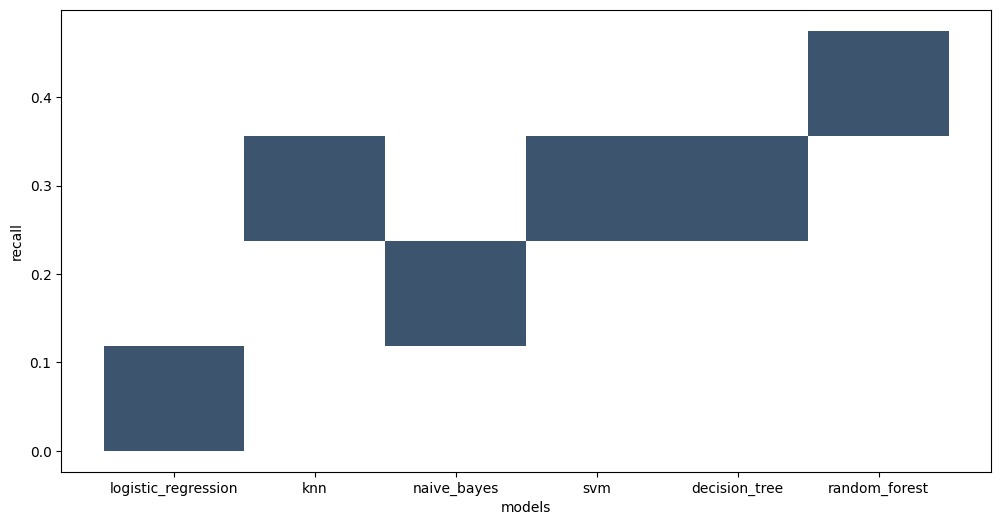

In [76]:
plt.figure(figsize=(12, 6)) 
sns.histplot(x= measurements['models'], y= measurements['recall'])
plt.show()

#### For the recall the highest values came from the random forest
#### And the winner is random forest

In [77]:
length = np.arange(len(measurements))

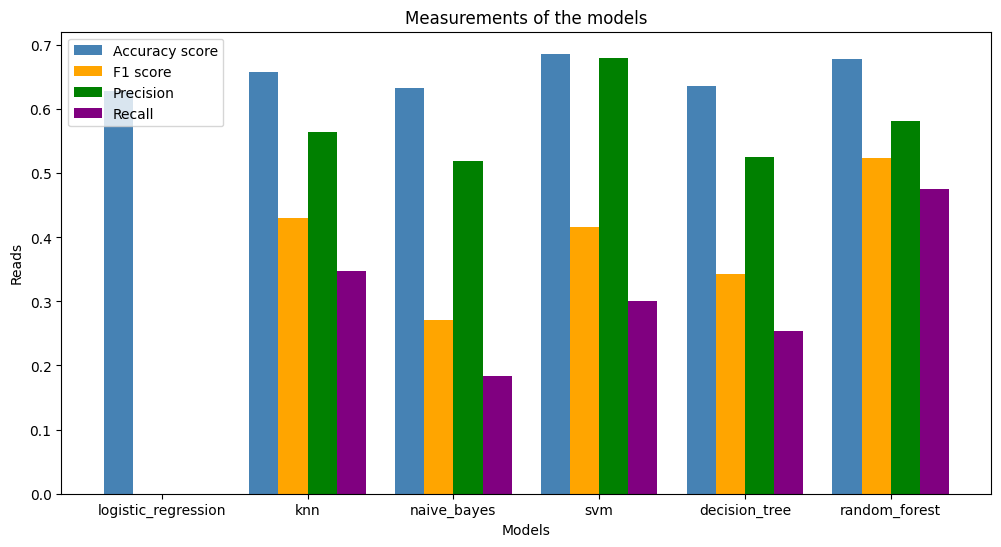

In [78]:
plt.figure(figsize= (12, 6))
plt.bar(length - 1.5 * 0.2, measurements['accuracy_score'], 0.2, label='Accuracy score', color='steelblue')
plt.bar(length - 0.5 * 0.2, measurements['f1_score'], 0.2, label='F1 score', color='orange')
plt.bar(length + 0.5 * 0.2, measurements['precision'], 0.2, label='Precision', color='green')
plt.bar(length + 1.5 * 0.2, measurements['recall'], 0.2, label='Recall', color='purple')
plt.title('Measurements of the models')
plt.xlabel('Models')
plt.ylabel('Reads')
plt.xticks(length, measurements['models']) 
plt.legend()
#plt.tight_layout()
plt.show()

#### Bar plot has all the values for all the measurments for each model

In [80]:
import plotly.graph_objects as go

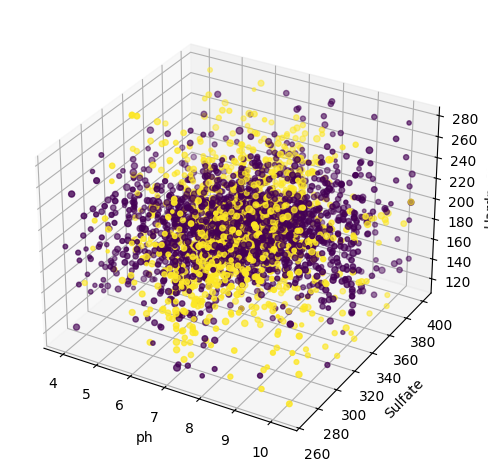

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(
    xs= df["ph"],
    ys=df["Sulfate"],
    zs= df["Hardness"],
    c= df["Potability"],
    s= df["Organic_carbon"]
           )

ax.set_xlabel("ph")
ax.set_ylabel("Sulfate")
ax.set_zlabel("Hardness")

plt.tight_layout()

In [ ]:
fig = go.Figure(data=go.Scatter3d(
    x=df["ph"],
    y=df["Sulfate"],
    z=df["Hardness"],
    mode='markers',
    marker=dict(
        size=5,
        color=df["Potability"],
        colorscale='Viridis',
        opacity=0.8
    )
))
fig.update_layout(scene=dict(
    xaxis_title='pH',
    yaxis_title='Sulfate',
    zaxis_title='Hardness'
))
fig.show()

#### 3d visual for the PH Sulfate Hardness
#### We can see that these three feature can not describe the classes

In [87]:
plt.Figure(figsize= (8, 8))
fig = go.Figure(data=go.Scatter3d(
    x=df["Conductivity"],
    y=df["Solids"],
    z=df["Turbidity"],
    mode='markers',
    marker=dict(
        size=5,
        color=df["Potability"],
        colorscale='Viridis',
        opacity=0.8
    )
))
fig.update_layout(scene=dict(
    xaxis_title='pH',
    yaxis_title='Sulfate',
    zaxis_title='Hardness'
))
fig.show()

In [88]:
fig = go.Figure(data=go.Scatter3d(
    x=df["Organic_carbon"],
    y=df["Solids"],
    z=df["Chloramines"],
    mode='markers',
    marker=dict(
        size=5,
        color=df["Potability"],
        colorscale='Viridis',
        opacity=0.8
    )
))
fig.update_layout(scene=dict(
    xaxis_title='pH',
    yaxis_title='Sulfate',
    zaxis_title='Hardness'
))
fig.show()

<h2><b>Summary</b><h2>


#### we made six Machine learining models :
1-(Logistic Regression)

2-(K-Nearest-Neighbor)

3-(Naive Bayes)

4-(Support Vector Machine)

5-(Decision Tree)

6-(Random Forest)

##### After that We visulaize the Confusion Matrix and  Calculated the Accurecy, recall, preicsion and F1-Score 

##### We Ploted the Data to see the Distribution for each Feature, and extract the insights form it

##### We visulaize the Accurecy, recall, preicsion and F1-Score for each Model in a column chart